In [1]:
import numpy as np
import pandas as pd

import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

shap.initjs()

In [2]:
MA_training = pd.read_csv('data/Massachusetts/train_test_split/training.csv')
MA_testing = pd.read_csv('data/Massachusetts/train_test_split/testing.csv')
MA_training = MA_training.drop(columns=['COUNTY', 'District Code', 'Year', 'Tests Taken'])  # Drop unnecessary columns
MA_testing = MA_testing.drop(columns=['COUNTY', 'District Code', 'Year', 'Tests Taken'])  # Drop unnecessary columns

In [3]:
WI_training = pd.read_csv('data/Wisconsin/train_test_split/training.csv')
WI_testing = pd.read_csv('data/Wisconsin/train_test_split/testing.csv')
WI_training = WI_training.drop(columns=['Unnamed: 0', 'COUNTY', 'STUDENTS_TESTED', 'EXAM_COUNT', 'EXAMS_3_OR_ABOVE', 'Year', 'Latitude', 'Longitude'])
WI_testing = WI_testing.drop(columns=['Unnamed: 0', 'COUNTY', 'STUDENTS_TESTED', 'EXAM_COUNT', 'EXAMS_3_OR_ABOVE', 'Year', 'Latitude', 'Longitude'])

In [4]:
GA_training = pd.read_pickle('data/GA_pickled/training.pkl').dropna(how='all')
GA_testing = pd.read_pickle('data/GA_pickled/testing.pkl').dropna(how='all')
GA_training = GA_training.drop(columns=['SCHOOL_DSTRCT_NM', 'TEST_CMPNT_TYP_NM', 'EXAM_COUNT', 'EXAMS_3_OR_ABOVE', 'Year', 'COUNTY', 'Latitude', 'Longitude'])
GA_testing = GA_testing.drop(columns=['SCHOOL_DSTRCT_NM', 'TEST_CMPNT_TYP_NM', 'EXAM_COUNT', 'EXAMS_3_OR_ABOVE', 'Year', 'COUNTY', 'Latitude', 'Longitude'])

In [5]:
data_all_training = pd.concat([MA_training, WI_training, GA_training], ignore_index=True)
data_all_testing = pd.concat([MA_testing, WI_testing, GA_testing], ignore_index=True)

In [6]:
# Define outcome and features
outcome = data_all_training.columns[0]       # Use the first column as the outcome
features = data_all_training.columns[1:]     # All other columns are features

X_train_full = data_all_training[features]
y_train = data_all_training[outcome]

X_test_full = data_all_testing[features]
y_test = data_all_testing[outcome]


# Impute missing values in the features
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')  # You can choose 'median', 'most_frequent', etc.
X_train_full = imputer.fit_transform(X_train_full)
X_test_full = imputer.transform(X_test_full)

# Perform PCA

In [7]:
# Standardize the features before applying PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test_full)

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f'Original number of features: {X_train_full.shape[1]}')
print(f'Reduced number of features after PCA: {X_train_pca.shape[1]}')

Original number of features: 19
Reduced number of features after PCA: 10


# Perform XGBoost

In [8]:
# Convert PCA-transformed data into DMatrix for XGBoost
dtrain_reg = xgb.DMatrix(X_train_pca, y_train)
dtest_reg = xgb.DMatrix(X_test_pca, y_test)

# Define XGBoost parameters
params = {
    "objective": "reg:squarederror",
    "tree_method": "hist",
    "max_depth": 3,
    "learning_rate": 0.2,
    "subsample": 0.8,
    "random_state": 216
}

n = 1000

evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

# Train the XGBoost model
xgb_model = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,
    evals=evals,
    verbose_eval=50,
    early_stopping_rounds=100
)

# Predict on the test set
y_pred = xgb_model.predict(dtest_reg)

# Compute RMSE on the test set
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Test RMSE: {test_rmse}')

[0]	train-rmse:17.88243	validation-rmse:17.97045
[50]	train-rmse:9.84719	validation-rmse:10.82685
[100]	train-rmse:8.26989	validation-rmse:9.66968
[150]	train-rmse:7.32850	validation-rmse:9.00036
[200]	train-rmse:6.75582	validation-rmse:8.73311
[250]	train-rmse:6.42729	validation-rmse:8.64812
[300]	train-rmse:6.17131	validation-rmse:8.54263
[350]	train-rmse:6.00808	validation-rmse:8.55688
[400]	train-rmse:5.88668	validation-rmse:8.57211
[410]	train-rmse:5.86677	validation-rmse:8.55757
Test RMSE: 8.557566343366863


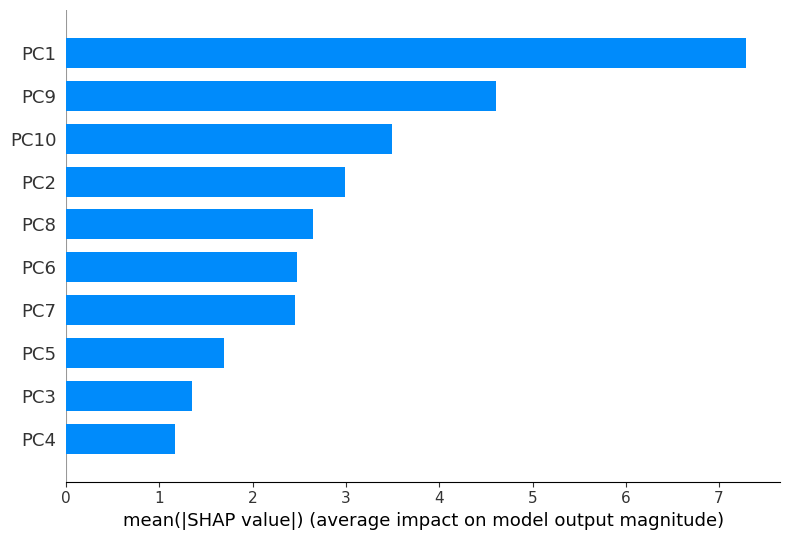

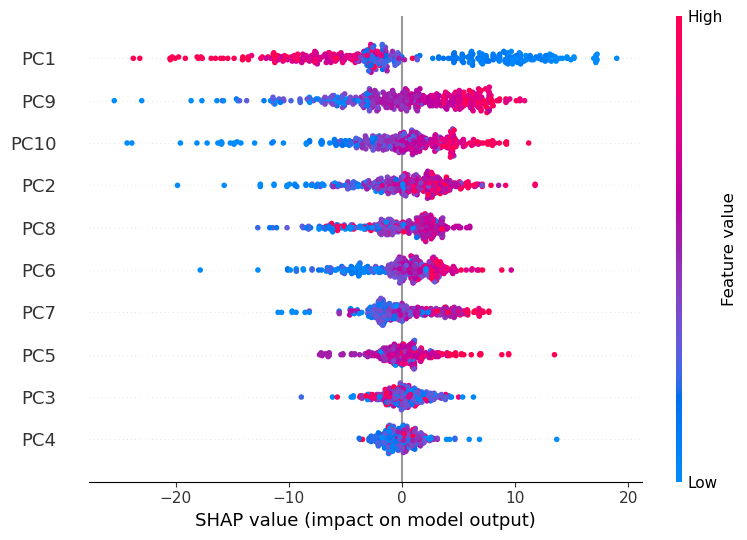

In [9]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_pca)

# Create a DataFrame for the PCA components
num_components = X_test_pca.shape[1]
component_names = [f'PC{i+1}' for i in range(num_components)]
X_test_pca_df = pd.DataFrame(X_test_pca, columns=component_names)

# Summary plot of SHAP values for principal components
shap.summary_plot(shap_values, X_test_pca_df, plot_type='bar')
shap.summary_plot(shap_values, X_test_pca_df)

# Compute approximate SHAP values for original features

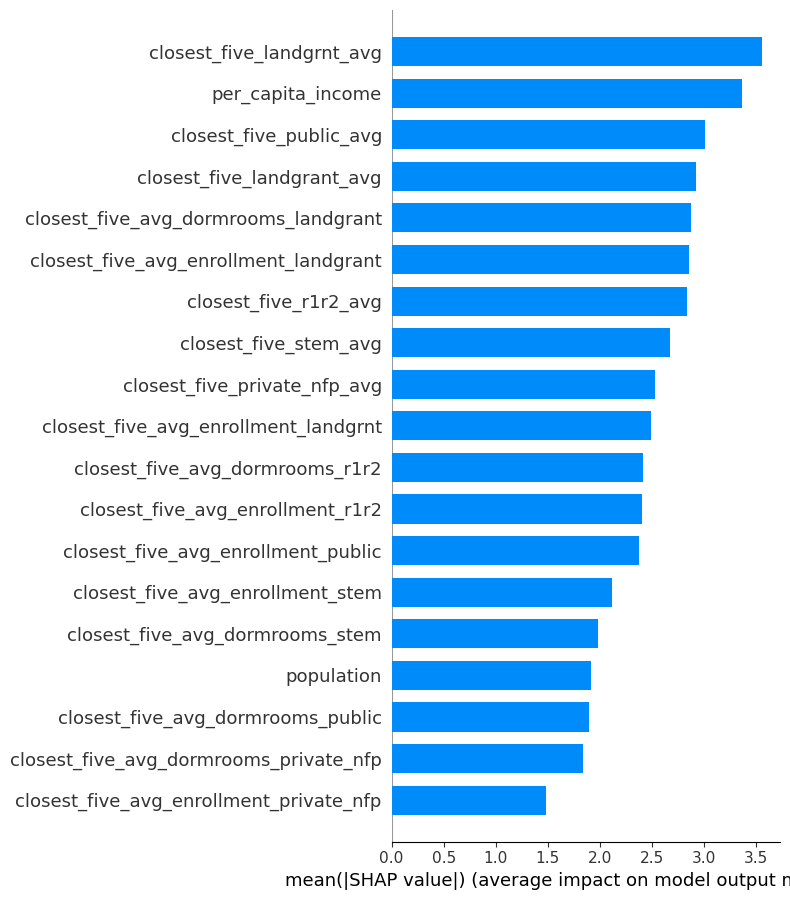

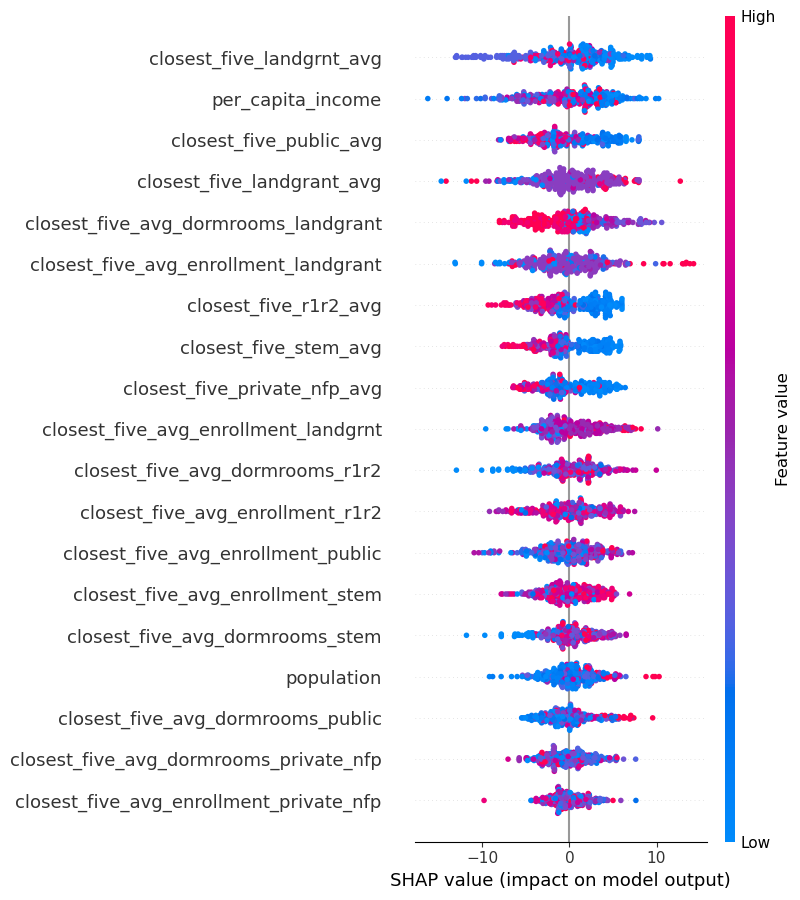

In [10]:
# shap_values_original = shap_values (n_samples x n_components)
# pca.components_ (n_components x n_features)
approx_shap_values = np.dot(shap_values, pca.components_)

# Create DataFrame for original features
X_test_original_df = pd.DataFrame(X_test_scaled, columns=features)

# Create SHAP summary plot for original features
shap.summary_plot(approx_shap_values, X_test_original_df, plot_type='bar')
shap.summary_plot(approx_shap_values, X_test_original_df)